### Enviroment preparation

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, Row
from pyspark.sql.types import *
import pyspark.sql.functions as F 
import numpy as np
import pandas as pd
import random
import time as t
import os
from subprocess import Popen
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
#ControlSparkCluster('stop')

In [3]:
def ControlSparkCluster(action):
    if action == 'start':
        Popen('./start_cluster.sh',shell=True)
        t.sleep(10)
        print 'cluster started'
    elif action == 'stop':
        Popen('./stop_cluster.sh',shell=True)
        sc.stop()
        t.sleep(3)
        print 'cluster stopped'
    else:
        raise Exception('Unsupported command!')

In [30]:
ControlSparkCluster('start')

cluster started


In [33]:
conf = SparkConf().setMaster("spark://cathome:7077").setAppName("bosh")\
.setAll((['spark.executor.cores','4']
        ,['spark.driver.cores','4']
        ,['spark.driver.memory','1g']
        ,['spark.executor.memory','1g']
        ,['spark.python.worker.memory','2g']
        ,['spark.default.parallelism','4']
       ))

In [34]:
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

### Data preparation

In [35]:
dir_name = '../../../diploma_data'

In [36]:
tr_num_file_name = 'train_numeric.csv'
tr_date_file_name = 'train_date.csv'
tr_cat_file_name = 'train_categorical.csv'
#ts_file_name = 'test_numeric.csv'

In [37]:
tr_num_data_file = '{0}/{1}'.format(dir_name,tr_num_file_name)
tr_date_data_file = '{0}/{1}'.format(dir_name,tr_date_file_name)
tr_cat_data_file = '{0}/{1}'.format(dir_name,tr_cat_file_name)

In [38]:
%%time
df_num = sqlContext.read.csv(tr_num_data_file, sep=',', header=True, inferSchema=True)
df_date = sqlContext.read.csv(tr_date_data_file, sep=',', header=True, inferSchema=True)
df_cat = sqlContext.read.csv(tr_cat_data_file, sep=',', header=True, inferSchema=True)

CPU times: user 48 ms, sys: 16 ms, total: 64 ms
Wall time: 4min 22s


### Data analisys/Data transformation

In [41]:
df2 = df_num
df3 = df_date
df4 = df_cat

In [43]:
def plt_hist(counts_by_col_l):
    row_fileds = counts_by_col_l[0].__fields__
    hist_v = map(float,[counts_by_col_l[0][key] for key in row_fileds])
    elems = list(xrange(0,len(hist_v)))     
    plt.figure(figsize=(18,5))
    plt.ylabel('proc')
    plt.xlabel('col id')
    plt.grid(True)
    plt.xlim([-10,len(elems) + 10])
    width = 1/1
    #plt.xticks(elems, row_fileds)
    plt.bar(elems, hist_v, width, color="blue")

In [44]:
def plt_pipe(counts_1_all_l):
    
    labels = 'Response:0', 'Response:1'
    sizes = (counts_1_all_l[0][0],counts_1_all_l[0][1])
    explode = (0.2, 0)  

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal') 

In [ ]:
counts_1_all_l = df2.select(F.sum(F.when(df2['Response'] == 1, 1).otherwise(0)).alias('count_1') , F.count('*').alias('count_all') ).collect()

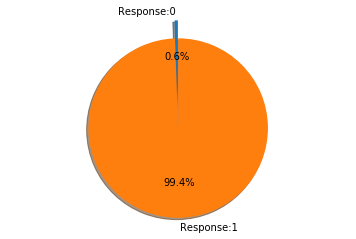

In [54]:
plt_pipe(counts_1_all_l)

In [12]:
counts_by_col = df2.select(*[(F.count(c) / F.count("*")).alias(c) for c in df2.columns])

In [13]:
counts_by_col.limit(10).toPandas()

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
0,1.0,0.569262,0.569262,0.569262,0.569262,0.569262,0.569262,0.569262,0.569262,0.569262,...,0.025647,0.025647,0.025647,0.025647,0.025647,0.050562,0.050562,0.050562,0.050562,1.0


In [14]:
counts_by_col_l = counts_by_col.collect()

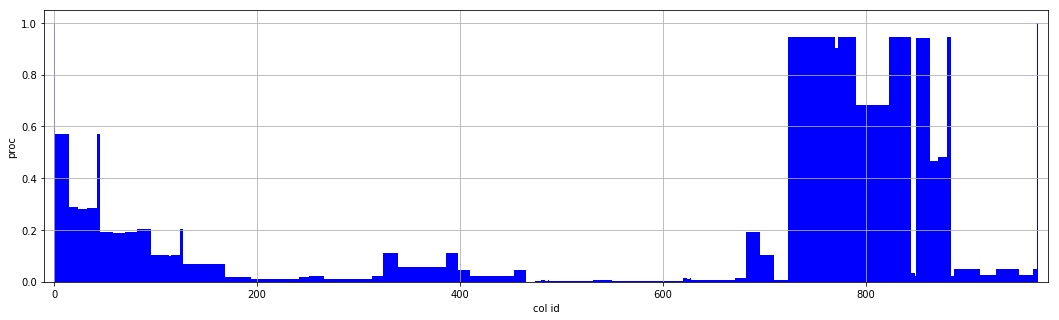

In [45]:
plt_hist(counts_by_col_l)

In [17]:
col_with_resp = df2.filter(df2.Response == 1 ).select(*[(F.count(c) / F.count("*")).alias(c) for c in df2.columns])

In [18]:
col_with_resp.limit(100).toPandas()

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
0,1.0,0.524495,0.524495,0.524495,0.524495,0.524495,0.524495,0.524495,0.524495,0.524495,...,0.022968,0.022968,0.022968,0.022968,0.022968,0.043902,0.043902,0.043902,0.043902,1.0


In [19]:
col_with_resp_l = col_with_resp.collect()

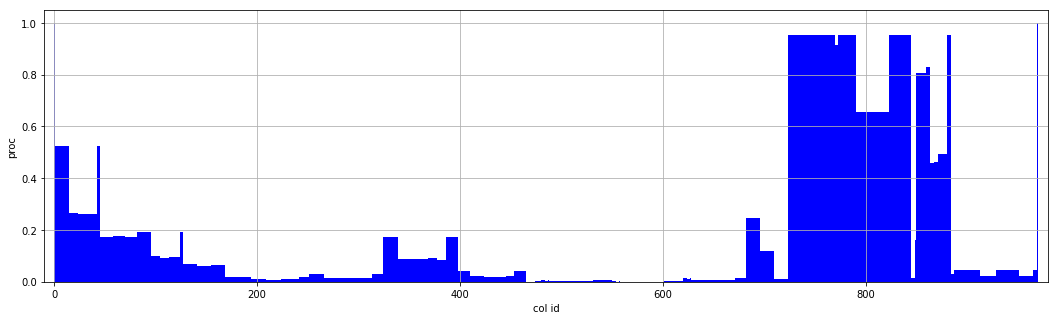

In [20]:
plt_hist(col_with_resp_l)

In [47]:
counts_by_col = df3.select(*[(F.count(c) / F.count("*")).alias(c) for c in df3.columns])

In [48]:
counts_by_col.limit(1).toPandas()

,Id,L0_S0_D1,L0_S0_D3,L0_S0_D5,L0_S0_D7,L0_S0_D9,L0_S0_D11,L0_S0_D13,L0_S0_D15,L0_S0_D17,...,L3_S50_D4246,L3_S50_D4248,L3_S50_D4250,L3_S50_D4252,L3_S50_D4254,L3_S51_D4255,L3_S51_D4257,L3_S51_D4259,L3_S51_D4261,L3_S51_D4263
0,1.0,0.569262,0.569262,0.569262,0.569262,0.569262,0.569262,0.569262,0.569262,0.569262,...,0.025647,0.025647,0.025647,0.025647,0.025647,0.050562,0.050562,0.050562,0.050562,0.050562


In [49]:
counts_by_col_l3 = counts_by_col.collect()

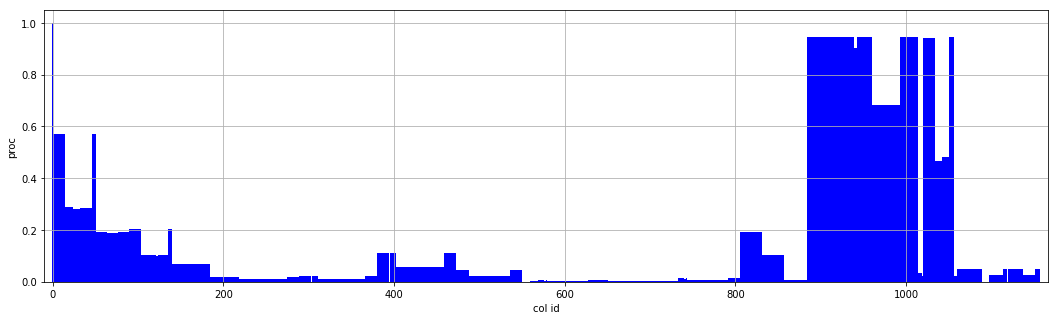

In [50]:
plt_hist(counts_by_col_l3)

In [51]:
counts_by_col4 = df4.select(*[(F.count(c) / F.count("*")).alias(c) for c in df4.columns])

In [52]:
counts_by_col_l4 = counts_by_col4.collect()

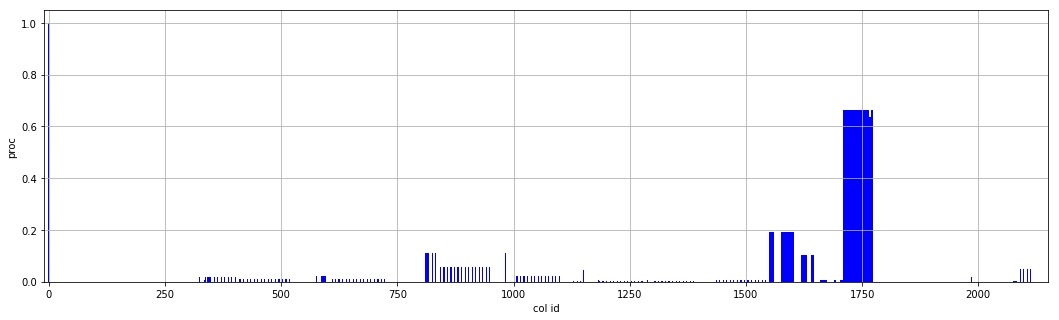

In [53]:
plt_hist(counts_by_col_l4)

### Creation of Models 

In [156]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [157]:
features = df2.columns[1:-1]

In [158]:
vecAssembler = VectorAssembler(inputCols=features, outputCol="features")

In [159]:
df2  = df2.na.fill(99999999)

In [ ]:
%%time
ass = vecAssembler.transform(df2)

In [161]:
assd = ass.select(['Id','Response','features']).drop()

In [162]:
assd.limit(5).toPandas()
assd.printSchema()

,Id,Response,features
0,4,0,"[0.03, -0.034, -0.197, -0.179, 0.118, 0.116, -..."
1,6,0,"[99999999.0, 99999999.0, 99999999.0, 99999999...."
2,7,0,"[0.088, 0.086, 0.003, -0.052, 0.161, 0.025, -0..."
3,9,0,"[-0.036, -0.064, 0.294, 0.33, 0.074, 0.161, 0...."
4,11,0,"[-0.055, -0.086, 0.294, 0.33, 0.118, 0.025, 0...."


root
 |-- Id: integer (nullable = true)
 |-- Response: integer (nullable = true)
 |-- features: vector (nullable = true)



In [163]:
tr_dt,tst_dt = assd.randomSplit([0.7,0.3])

In [164]:
gbt = GBTClassifier(maxIter=5, maxDepth=2, labelCol="Response", seed=42)

In [165]:
%%time
model = gbt.fit(tr_dt)

CPU times: user 112 ms, sys: 36 ms, total: 148 ms
Wall time: 16min 26s


In [166]:
model.featureImportances

SparseVector(968, {341: 0.3003, 356: 0.087, 394: 0.0424, 765: 0.1811, 848: 0.215, 855: 0.041, 883: 0.1333})

In [167]:
pr = model.transform(tst_dt)

In [169]:
pr.show()

+---+--------+--------------------+----------+
| Id|Response|            features|prediction|
+---+--------+--------------------+----------+
|  4|       0|[0.03,-0.034,-0.1...|       0.0|
|  6|       0|[9.9999999E7,9.99...|       0.0|
| 14|       0|[9.9999999E7,9.99...|       0.0|
| 47|       0|[9.9999999E7,9.99...|       0.0|
| 52|       0|[9.9999999E7,9.99...|       0.0|
| 55|       0|[9.9999999E7,9.99...|       0.0|
| 71|       0|[-0.167,-0.168,0....|       0.0|
| 78|       0|[0.101,0.108,0.00...|       0.0|
| 79|       0|[9.9999999E7,9.99...|       0.0|
| 81|       0|[0.036,0.078,-0.1...|       0.0|
| 91|       0|[0.036,0.101,-0.1...|       0.0|
| 92|       0|[0.108,0.093,-0.0...|       0.0|
| 95|       0|[0.088,0.071,-0.0...|       0.0|
|103|       0|[-0.055,-0.041,-0...|       0.0|
|115|       0|[0.075,0.056,-0.1...|       0.0|
|123|       0|[-0.023,-0.034,-0...|       0.0|
|126|       0|[0.095,0.056,-0.1...|       0.0|
|131|       0|[-0.003,0.041,0.3...|       0.0|
|146|       0

In [168]:
label_pred_list = pr.select(pr['Response'],pr['prediction']).collect()
matthews_corr_coef(label_pred_list)

True Positives: 6
True Negatives: 352534
False Positives: 0
False Negatives: 2040
Matthews correlation coefficient:  0.0539970298159


### Testing Models

### Results evaluation

In [121]:
def matthews_corr_coef(label_pred_list): 
    
    tp = np.sum(1 for r in label_pred_list if r[0] == 1 and r[1] == 1)
    tn = np.sum(1 for r in label_pred_list if r[0] == 0 and r[1] == 0)
    fp = np.sum(1 for r in label_pred_list if r[0] == 0 and r[1] == 1)
    fn = np.sum(1 for r in label_pred_list if r[0] == 1 and r[1] == 0)
    print "True Positives:", tp
    print "True Negatives:", tn
    print "False Positives:", fp
    print "False Negatives:", fn
    #print "Total", df.count()
    try:
        MCC = ((tp * tn) - (fp * fn)) / np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))
    except ZeroDivisionError:
        MCC = -1
    print "Matthews correlation coefficient: ", MCC